# Experiment: Diagonal

# Setup

In [1]:
from IPython.display import clear_output
import jax
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import xjax
from xjax.signals import train_epoch_completed

In [2]:
rng = jax.random.key(42)

# Dataset

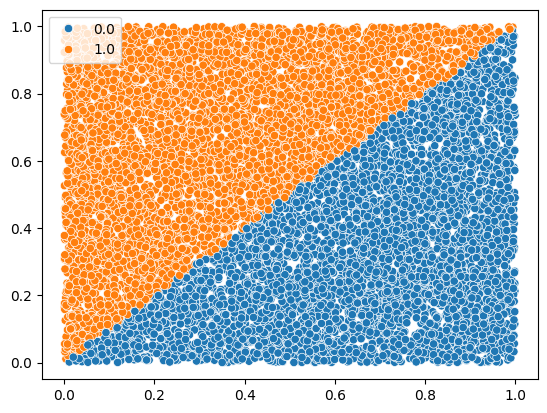

In [3]:
rng, dataset_rng = jax.random.split(rng)
X, y = xjax.datasets.diagonal(rng=dataset_rng)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

fig, ax = plt.subplots()
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, ax=ax)
ax.legend(loc="upper left")

# Modeling

## Baseline

In [4]:
# Construct model
model_lr = xjax.models.sklearn.logistic_regression()

In [5]:
# Train model
model_lr = xjax.models.sklearn.train(model_lr, X=X_train, y=y_train)

In [6]:
# Test model
y_score_lr = xjax.models.sklearn.predict(model_lr, X=X_test)
auroc_lr = roc_auc_score(y_test, y_score_lr)

print(f"LR AUROC: {auroc_lr:0.4f}")

LR AUROC: 1.0000


## Candidate

In [7]:
# Hyperparameters
batch_size=3
epochs=5
learning_rate=0.01

In [8]:
# Construct model
rng, model_rng = jax.random.split(rng)
model_nn, params = xjax.models.flax.mlp(rng=model_rng, inputs=2, outputs=1)

In [9]:
# Monitor model
loss_hx = []

@train_epoch_completed.connect_via(model_nn)
def monitor_model(model, epoch, loss, **_):
    loss_hx.append(loss)
    xjax.plots.loss_history(loss_hx)

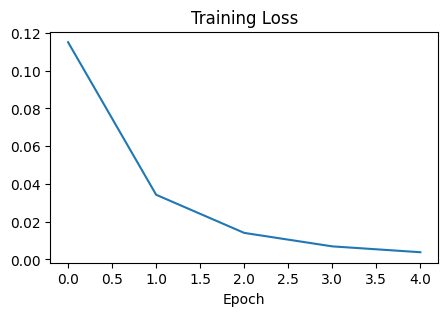

In [10]:
# Train model
params = xjax.models.flax.train(
    model_nn,
    params=params,
    X=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    learning_rate=learning_rate,
)

In [11]:
# Test model
y_score_nn = xjax.models.flax.predict(model_nn, params=params, X=X_test)
auroc_nn = roc_auc_score(y_test, y_score_nn)

print(f"NN AUROC: {auroc_nn:0.4f}")

NN AUROC: 1.0000


# Analysis

## Predictions

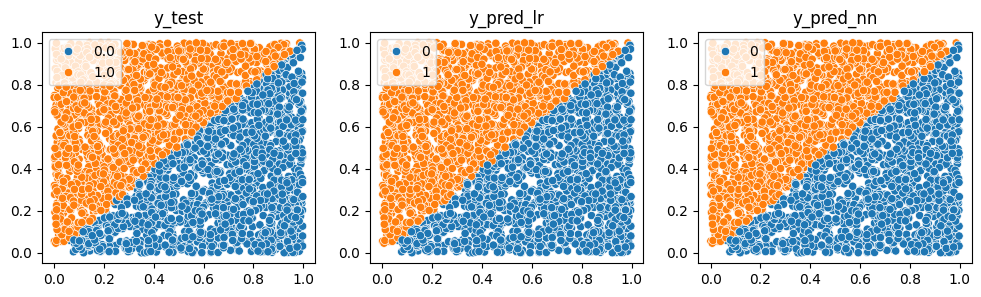

In [12]:
y_pred_lr = (y_score_lr > 0.5).astype(int)
y_pred_nn = (y_score_nn > 0.5).astype(int)

fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=y_test, ax=axs[0])
axs[0].set_title("y_test")
axs[0].legend(loc="upper left")

sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=y_pred_lr, ax=axs[1])
axs[1].set_title("y_pred_lr")
axs[1].legend(loc="upper left")

sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=y_pred_nn, ax=axs[2])
axs[2].set_title("y_pred_nn")
axs[2].legend(loc="upper left")